In [1]:
%matplotlib inline
import numpy as np
from astropy import units as u
from astropy import constants as const
from galaxy_analysis.plot.plot_styles import *


from scipy.integrate import quad

from onezone import imf
from onezone import data_tables as DT

import matplotlib.pyplot as plt

def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()


SE_TABLE= DT.StellarEvolutionData()

In [2]:

def Kobayashi_mass_ranges(Z, SN_type, mass_type):
    """
    Table 1 of Kobayashi+2015
    
    Z is nominally [Fe/H]. For ease, no interpolation
    is done in [Fe/H]. Values are just rounded up / down
    to nearest grid point.
    """
    
    grid_points = np.array([-2.5,-2.4,-2.0,-1.1,-1,-0.7,0.0,0.4])
    
    if Z < -3.0:
        if SN_type == 'Ia' or SN_type == 'Iax':
            return (0.0,0.0)
        elif SN_type == 'Sch':
            
            if mass_type == 'RG':
                return (0.0,0.0)
            elif mass_type == 'MS':
                return (0.835, 1.350)
            elif mass_type == 'Iax':
                return (5.9,6.9)
            
    Kobayashi_dict = {
        
        'Ia'  : {'RG' : [(0,0),(0,0),(0,0),(0.9,0.9),(0.9,1.5),(0.9,2.0),(0.9,3.0),(0.8,3.5)],
                 'MS' : [(0,0),(0,0),(0,0),(1.8,1.8),(1.8,2.6),(1.8,4.0),(1.8,5.5),(1.8,6.0)],
                 'WD' : [(0,0),(0,0),(0,0),(2.4,6.9),(2.5,7.0),(2.8,7.3),(3.5,8.0),(3.9,8.4)]},
        'Sch' : {'RG' : [(0,0),(0,0),(0,0),(0,0),(0.835,1.0),(0.835,1.3),(0.835,1.9),(0.835,2.4)],
                 'MS' : [(0.835,1.35),(0.835,1.35),(0.835,1.35),(0.835,1.35),(0.835,1.35),(1.05,1.9),(1.05,1.9),(1.05,1.9),(1.05,1.9)],
                 'WD' : [(5.9,6.9),(5.9,6.9),(5.9,6.9),(5.9,6.9),(5.9,6.9),(6.0,7.0),(6.3,7.3),(7.0,8.0),(7.8,8.8)]}
    }
              

    z_index = np.argmin(np.abs(grid_points-Z))
    
    return Kobayashi_dict[SN_type][mass_type][z_index]

In [3]:
from onezone import imf

Kroupa = imf.kroupa()
IMF    = Kroupa.imf

hubble_time = (13.8 * u.Gyr).to(u.s).value

def IMF_secondary(m,m_min,m_max,slope = -0.35):
    
    intnorm = lambda x : x**(slope-1)
    
    norm = 1.0 / quad(intnorm, m_min,m_max)[0]
    
    return norm * m**(slope)
    
    
    return

def DTD(t, m_max = 8.0, slope=-1.2, norm = 1.0):
    
    #return 1.0E-4

    dPdt =  (slope+1.0)/((hubble_time)**(slope+1.0) - (t_m(m_max)**(slope+1.0)))
    
    return dPdt * (t)**(slope)


datadir = '/home/aemerick/code/onezone/Data/'

parsec_data = np.genfromtxt(datadir + 'parsec_data.in', names=True)

def t_m(x, Z = 0.008):
    """
    Lifetime vs. mass
    """
    
    M  = parsec_data['M'][Z==parsec_data['Z']]
    lt = parsec_data['lifetime'][Z==parsec_data['Z']]
    
    return np.interp(x,M,lt)

def inv_lifetime(x, Z = 0.004):
    
    M  = parsec_data['M'][Z==parsec_data['Z']]
    lt = parsec_data['lifetime'][Z==parsec_data['Z']]
    
    if x < lt[-1]:
        return M[-1]
    if x > lt[0]:
        return M[0]
    
    return np.interp(x,lt[::-1],M[::-1])

In [4]:
print((parsec_data['lifetime'][0.004==parsec_data['Z']] * u.s).to(u.Myr))
print(parsec_data['M'][0.004==parsec_data['Z']])

[9.00911825e+03 7.52186795e+03 1.09123843e+03 3.55458558e+02
 1.72599149e+02 1.03400563e+02 5.07187746e+01 3.97507383e+01
 2.65464655e+01 1.96742972e+01 1.56331042e+01 1.30670786e+01
 1.12929304e+01 9.99848848e+00 8.26394054e+00 7.14613215e+00
 6.72978268e+00 5.94097301e+00 5.38848138e+00 4.66212228e+00
 4.41671071e+00 4.20958058e+00 3.89040263e+00 3.48322750e+00
 3.33678068e+00 3.12418213e+00] Myr
[  0.95   1.     2.     3.     4.     5.     7.     8.    10.    12.
  14.    16.    18.    20.    24.    28.    30.    35.    40.    50.
  55.    60.    70.    90.   100.   120.  ]


In [5]:
def rate(time, Z, SN_type):
    
    b = 0.023
    
    #int1 = lambda x : 1/x * IMF(x)
    
    def int1(x, m_min, m_max):
        
        intnorm = lambda _x : IMF(_x)
        norm = 1.0 / quad(intnorm, m_min,m_max)[0]
   
        return norm/x * IMF(x)
    
    def int2(x, t, m_min, m_max):
        
        if t <= t_m(x):
            return 0.0
        else:
            return 1/x * DTD(t-t_m(x),m_max) * IMF_secondary(x, m_min, m_max)
    
    
    if np.size(time) == 1:
        time = np.array([time])
    
    total_rate = np.zeros(np.size(time))
    
    m_d_min, m_d_max = Kobayashi_mass_ranges(Z, SN_type, 'WD')    
    for i,t in enumerate(time):
        
        m_t_min  = inv_lifetime(t)
        
        m_d_min_ = np.max( [m_d_min, m_t_min])
            
        for primary in ['RG','MS']:
            
            m_p_min, m_p_max = Kobayashi_mass_ranges(Z, SN_type, 'RG')
            
            
            m_p_min = np.max( [m_p_min, m_t_min])
            
            #print(m_t_min, m_p_min, m_p_max, m_d_min_, m_d_max)
            
            if m_p_min >= m_p_max:
                total_rate[i] = 0.0
                continue
                
            if m_d_min_ >= m_d_max:
                total_rate[i] = 0.0
                continue
                
            
            val1 = quad(int1, m_p_min, m_p_max, args=(m_p_min,m_p_max,))[0]
            val2 = quad(int2, m_d_min_, m_d_max, args=(t,m_d_min_,m_d_max,))[0]   
            
            
            #print(m_t_min, m_p_min, m_p_max, m_d_min_, m_d_max, val1, val2, (t*u.s).to(u.Myr), (t_m(m_d_min_)*u.s).to(u.Myr))
            
            total_rate[i] += b * val1 * val2
                             
    
    
    return total_rate
    
    
    
    

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


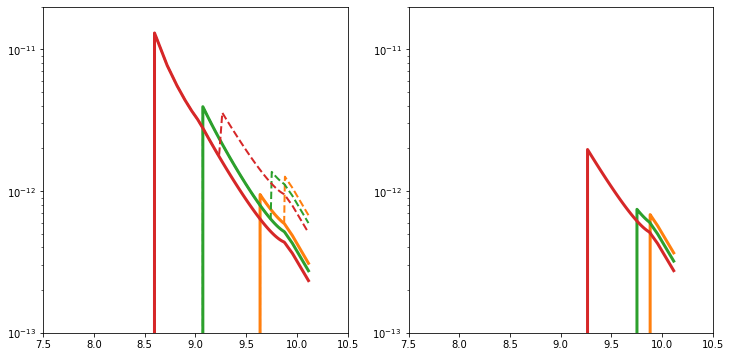

In [6]:
times = np.linspace(1.0,13000.0,100)

times = (times * u.Myr).to(u.s).value

colors = {-3.0:'black',-1.1:'C0',-1.0:'C1',-0.7:'C2',0.0:'C3'}


fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

x = np.log10((times * u.s).to(u.yr).value)

for Z in [-3.0,-1.1,-1.0,-0.7,0.0]:
    
    
    yia = (rate(times, Z, 'Ia') / u.s).to(1.0/u.yr).value
    ax[0].plot(x, yia, lw = 3, color = colors[Z])
    
    ysch = (rate(times, Z, 'Sch') / u.s).to(1.0/u.yr).value
    ax[1].plot(x, ysch, lw = 3, color = colors[Z])
    
    ax[0].plot(x,yia+ysch,lw=2,color=colors[Z],ls='--')
    
    
    ax[0].semilogy()
    ax[1].semilogy()
    
    ax[0].set_ylim(1.0E-13,2.0E-11)
    ax[1].set_ylim(ax[0].get_ylim())
    
    ax[0].set_xlim(7.5,10.5)
    ax[1].set_xlim(ax[0].get_xlim())

In [8]:
#
#
# I could at least compute this fraction
#
#
NSNIa = 0.8E-3

Kroupa = imf.kroupa()
Kroupa.M_min = 0.08
Kroupa.M_max = 100.0

num   = lambda x : Kroupa.imf(x)
denom = lambda x : Kroupa.imf(x)/x

M_min_snia = 3.0
M_max_snia = 8.0

val1 = quad(num, 0.08, 120.0)[0]
val2 = quad(denom, M_min_snia, M_max_snia)[0]

print(val1,val2)

print(NSNIa * val1/val2)

print(val1/val2)

4.900074149318325 0.031104542113057077
0.1260285171601705
157.53564645021314


AttributeError: 'kroupa' object has no attribute '_tabulated_imf'

In [153]:
#
#
# I could at least compute this fraction
#
#
Salpeter = imf.salpeter()

NSNIa = 0.8E-3

num   = lambda x : Salpeter.imf(x)
denom = lambda x : Salpeter.imf(x)/x

M_min_snia = 3.0
M_max_snia = 8.0

val1 = quad(num, Salpeter.M_min, 100.0)[0]
val2 = quad(denom, M_min_snia, M_max_snia)[0]

print(val1,val2)

print(NSNIa * val1/val2)

2.287067910008891 0.12337485159877576
0.014830042786655465


In [10]:
def Ruiter_modelA1(t, sntype):
    
    times = np.array([0.1,0.5,1.0,3.0,5.0,10.0]) * 1.0E9 # in yr
    
    rates = {'DDS' : 1.0E-12*np.array([0.2,0.16,0.08,0.025,0.012,0.005]),
             'SDS' : 1.0E-12*np.array([0.0,0.001,0.015,0.002,0.001,0.001]),
             'HeRS' : 1.0E-12*np.array([0.003,0.022,0.008,0.001,0.0001,0.0]),
             'sCh'  : 1.0E-12*np.array([0.1,0.001,0.33,0.04,0.014,0.004])}
    
    
    
    if np.size(t) > 1:
    
        r = np.zeros(np.size(t))
    
        r[t<times[0]]  = 0.0
        slope = (rates[sntype][-2] - rates[sntype][-1])/(times[-2]-times[-1])
        b     = rates[sntype][-1] - slope * times[-1]
        r[t>times[-1]] =  slope * t[t>times[-1]] + b
        
        select = (t>=times[0])*(t<=times[-1])
        r[select] = np.interp(t[select], times, rates[sntype])

        r[r<0] = 0.0

        return r
    
    else:
        if t < times[0]:
            return 0.0
        elif t > times[-1]:
            slope = (rates[sntype][-2] - rates[sntype][-1])/(times[-2]-times[-1])
            b     = rates[sntype][-1] - slope * times[-1]     
            
            return np.max([0.0,slope*t+b])
    
        return np.interp(t, times, rates[sntype])
    
    
    

In [11]:

#
#
#
#

from onezone.physics import WD_lifetime
from onezone import config

t_H = config.units.hubble_time(0.0) * 1.0E6 # in yr



yr_s = 3.154e+7
DTD_slope = 1.2


class SNIa_model():

    def __init__(self, sntype, npoints = 1000):
        
        self.sntype = sntype
        self.npoints = npoints
        
        self.min_time = np.log10(1.0E4)  # yr
        self.max_time = np.log10(t_H) # yr

        Kroupa = imf.kroupa()
        Kroupa.M_min = 0.08
        Kroupa.M_max = 120.0
    
        eta_int = lambda x, s : Ruiter_modelA1(x, s)
        
        #
        # My IMF is stored as M^(alpha) where alpha = 1.35 for salpeter 
        # so integral over this IMF gives MASS and integral over IMF/M gives number
        #
        f_num   = lambda x : Kroupa.imf(x)
        f_denom = lambda x : Kroupa.imf(x)/x
        
        
        self.M_min_snia = 3.0
        self.M_max_snia = 8.0
        
        val1 = quad(eta_int, 0.0, t_H, args=(self.sntype,))[0]
        val2 = quad(f_num, Kroupa.M_min, Kroupa.M_max)[0]
        val3 = quad(f_denom, self.M_min_snia, self.M_max_snia)[0]
        
        
        self.eta = val1 * val2 / val3
        
        #print(val1, val2/val3)
        
        self._prob_norm = self.eta / val1
        #print(val1, val2, val3, val2/val3, self.eta, self.eta/val1)
        
        self._total_norm = 0.0
        
        for m in ['DDS','SDS','HeRS','sCh']:
            self._total_norm += quad(eta_int,0.0,t_H,args=(m,))[0]
        self._self_norm = val1
        
        
        self._tabulate_data()
        
        
        return
    
    def probability(self,t):
        """
        Probability of SNIa happening at time t (yr)
        """
    
        #p = self._prob_norm * Ruiter_modelA1(t, self.sntype)
        
        p = Ruiter_modelA1(t, self.sntype) *self._prob_norm
        
        return p
    
    def _tabulate_data(self):
        
        dt = (self.max_time-self.min_time)/(1.0*(self.npoints-1))
        
        self._tabulated_time = 10.0**(self.min_time + dt * np.arange(self.npoints))
        
        self._tabulated_prob = np.zeros(self.npoints)
        
        self._tabulated_prob[0] = self.probability(self._tabulated_time[0])
        
        temp = self.probability(self._tabulated_time)
        
        f_a = temp[:-1]
        f_b = temp[1:]
        
        f_ab = self.probability(0.5 * (self._tabulated_time[1:] + self._tabulated_time[:-1]))
        
        self._tabulated_prob[1:] = (1.0/6.0)*(self._tabulated_time[1:]-self._tabulated_time[:-1])*(f_a+4.0*f_ab+f_b)
        self._tabulated_prob     = np.cumsum(self._tabulated_prob)
        
        return
    
    def explosion_time(self, gauruntee = False):
        
        rnum = np.random.random()
        
        norm = 1.0
        if gauruntee:
            norm = 1.0 / self._tabulated_prob[-1]
        
        if (rnum < self._tabulated_prob[0] * norm):
            print("WARNING: Death immediate")
            t = self._tabulated_time[0]
        elif (rnum > self._tabulated_prob[-1] * norm):
            t = np.inf
            
        else:
            
            t = self._tabulated_time[ np.abs(self._tabulated_prob*norm - rnum).argmin()]
        
        return t
    

#

class old_SNIa_model():

    def __init__(self, DTD_slope = 1.2, NSNIa = 0.8E-3, npoints = 1000):
        
        self.DTD_slope = DTD_slope
        
        self.npoints = npoints
        
        self.min_time = np.log10(1.0E6)  # yr
        self.max_time = np.log10(t_H) # yr

        Kroupa = imf.kroupa()
        Kroupa.M_min = 0.08
        Kroupa.M_max = 120.0
    
        #eta_int = lambda x, s : Ruiter_modelA1(x, s)
        
        f_num   = lambda x : Kroupa.imf(x)
        f_denom = lambda x : Kroupa.imf(x)/x
        
        
        self.M_min_snia = 3.0
        self.M_max_snia = 8.0
        
        #val1 = quad(eta_int, 0.0, t_H, args=(self.sntype,))[0]
        val2 = quad(f_num, Kroupa.M_min, Kroupa.M_max)[0]
        val3 = quad(f_denom, self.M_min_snia, self.M_max_snia)[0]
        
        val1 = NSNIa
        
        self.eta = val1 * val2 / val3
        
        
        self._prob_norm = self.eta / val1
        
        #self._total_norm = 0.0
        #
        #for m in ['DDS','SDS','HeRS','sCh']:
        #    self._total_norm += quad(eta_int,0.0,t_H,args=(m,))[0]
        #self._self_norm = val1
        
        
        self._tabulate_data()
        
        
        return
    
    def probability(self, t, lifetime=100.0E6):
        """
        Probability of SNIa happening at time t (yr)
        """
    
        #p = self._prob_norm * Ruiter_modelA1(t, self.sntype)
        
        dPdt = self.eta

        if (self.DTD_slope == 1.0):
            dPdt /= np.log( (t_H) / ( lifetime ))
        else:
            dPdt *= (- self.DTD_slope + 1.0)
            dPdt /= ( (t_H)**(-self.DTD_slope + 1.0) -\
                      (lifetime)**(-self.DTD_slope+1.0))
    
        dPdt *= (t)**(-self.DTD_slope)        
    
        return dPdt
    
    def _tabulate_data(self):
        
        dt = (self.max_time-self.min_time)/(1.0*(self.npoints-1))
        
        self._tabulated_time = 10.0**(self.min_time + dt * np.arange(self.npoints))
        
        self._tabulated_prob = np.zeros(self.npoints)
        
        self._tabulated_prob[0] = self.probability(self._tabulated_time[0]+100.0E6)
        
        temp = self.probability(self._tabulated_time+100.0E6)
        
        f_a = temp[:-1]
        f_b = temp[1:]
        
        f_ab = self.probability(0.5 * (self._tabulated_time[1:] + self._tabulated_time[:-1]) + 100.0E6)
        
        self._tabulated_prob[1:] = (1.0/6.0)*(self._tabulated_time[1:]-self._tabulated_time[:-1])*(f_a+4.0*f_ab+f_b)
        self._tabulated_prob     = np.cumsum(self._tabulated_prob)
        
        return
    
    def explosion_time(self, gauruntee = False):
        
        rnum = np.random.random()
        
        norm = 1.0
        if gauruntee:
            norm = 1.0 / self._tabulated_prob[-1]
        
        if (rnum < self._tabulated_prob[0] * norm):
            print("WARNING: Death immediate")
            t = self._tabulated_time[0]
        elif (rnum > self._tabulated_prob[-1] * norm):
            t = np.inf
            
        else:
            
            t = self._tabulated_time[ np.abs(self._tabulated_prob*norm - rnum).argmin()]
        
        return t    

In [12]:
rates = {}

s =0.0
for sntype in ['DDS','SDS','sCh','HeRS']:
    rates[sntype] = SNIa_model(sntype)
    
    #print(sntype,rates[sntype]._tabulated_prob[-1], rates[sntype].eta)
    
    print(sntype, rates[sntype]._tabulated_prob[-1])
    s += rates[sntype]._tabulated_prob[-1]
    
print(s)    

old_model = old_SNIa_model()
old_model.eta

#old_model.explosion_time(gauruntee=False)

DDS 0.05126958193824957
SDS 0.005242912915506227
sCh 0.09073471211157359
HeRS 0.0035997607307840106
0.15084696769611342


0.1260285171601705

In [12]:
M_SF = 5.0E7
stars = Kroupa.sample(M =M_SF)
total_mass = np.sum(stars)

stars = stars[(stars>3.0)*(stars<8.0)]


In [13]:

MS_lifetime = np.zeros(np.size(stars))
#total_mass = np.sum(stars)

lifetimes = {}
for k in ['old','new']:
    lifetimes[k] = np.ones(np.size(stars))*np.inf
    
select = (stars>=3.0)*(stars<=8.0)
nselect = np.size(stars[select])
#lifetimes['old'][select] = np.array([WD_lifetime(0.0,0.0,100.0,DTD_slope=DTD_slope,NSNIa=0.023) for a in np.arange(nselect)])


probs_list = ['DDS','SDS','HeRS','sCh']
prob = np.zeros(4)
for i,k in enumerate(probs_list):
    prob[i] = rates[k]._tabulated_prob[-1]
prob = np.cumsum(prob)


explosion_type = np.array(["None"]*len(stars))
for i,s in enumerate(stars):
    
    if (s >= 3.0) and (s <= 8.0):
        _s = s
        if _s < SE_TABLE.x['mass'][0]:
            _s = SE_TABLE.x['mass'][0]
        elif _s > SE_TABLE.x['mass'][-1]:
            _s = SE_TABLE.x['mass'][-1]
        
        MS_lifetime[i] = 0.0 #SE_TABLE.interpolate([_s,0.01], ['lifetime'])[0]
        MS_lifetime = MS_lifetime / yr_s / 1.0E9
        
        lifetimes['old'][i] = old_model.explosion_time() #WD_lifetime(0.0,0.0,100.0,DTD_slope=DTD_slope,NSNIa=0.023)
        # random number pick the SN type
        rnum = np.random.rand()
        if rnum > prob[-1]: # no Ia
            lifetimes['new'][i] = np.inf
            
        else:
            index = np.argmin(np.abs(prob-rnum))
            
            if (rnum > prob[index]):
                index = index + 1
                
            if rnum > prob[index]:
                print(prob, index, rnum)
                raise RuntimeError
            
            sntype              = probs_list[index]
            lifetimes['new'][i] = rates[sntype].explosion_time(gauruntee=True)
            explosion_type[i]   = sntype
    else:
        lifetimes['new'][i] = np.inf
        lifetimes['old'][i] = np.inf
        explosion_type[i] = "None"
        


In [14]:
#
#
# Plot the rates by binning up the results
#
dt    = 0.1
bins  = np.arange(0.0,14.0,dt)

old_hist, dum = np.histogram(lifetimes['old'][lifetimes['old']<np.inf] + MS_lifetime[lifetimes['old']<np.inf], bins = bins*1.0E9)

new_hist = {}
for k in ['DDS','SDS','HeRS','sCh']:
    select = (lifetimes['new'] < np.inf)*(explosion_type==k)
    
    hist, dum = np.histogram(lifetimes['new'][select], bins = bins*1.0E9)
    new_hist[k] = 1.0*hist

/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10
/home/aemerick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


Ratio of new to old total amount of SNIa at given time intervals
t < 0.25 Gyr:  0.17297
t < 0.50 Gyr:  0.28333
t < 0.75 Gyr:  0.36046
t < 1.00 Gyr:  0.54287
t < 2.00 Gyr:  1.03394
t < 10.00 Gyr:  1.22066
t < 14.00 Gyr:  1.19147


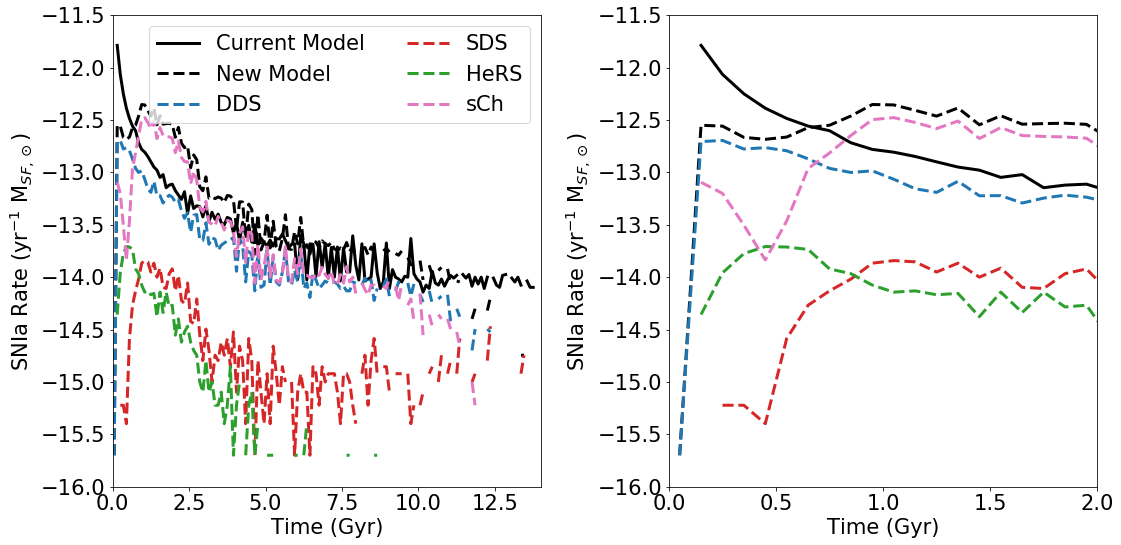

In [17]:
plot_settings()

fig, all_axes = plt.subplots(1,2)
fig.set_size_inches(16,8)

cent = 0.5 * (bins[1:]+bins[:-1])

# convert to / yr / Msun of SF
norm = 1.0 / (dt*1.0E9) / total_mass

for ax in all_axes:
    ax.plot(cent + 0.1, np.log10(old_hist * norm), label = 'Current Model',lw = 3, color = 'black')

    new_total = np.zeros(np.size(old_hist))

    colors = {'DDS' : 'C0','SDS':'C3','HeRS':'C2','sCh':'C6'}

    for i,k in enumerate(['DDS','SDS','HeRS','sCh']):
        new_total += new_hist[k]


        #ax.plot(cent, np.log10(Ruiter_modelA1(cent*1.0E9,k)),lw=2,ls='--', color = "C%i"%(i))    

    ax.plot(cent, np.log10(new_total * norm), label = 'New Model', lw = 3, color = 'black', ls = '--')

    for i,k in enumerate(['DDS','SDS','HeRS','sCh']):

        ax.plot(cent, np.log10(new_hist[k] * norm), label = k, lw =3, color = colors[k], ls = '--')

    ax.set_ylim(-16,-11.5)
 
    ax.set_ylabel(r'SNIa Rate (yr$^{-1}$ M$_{SF,\odot}$)')
    ax.set_xlabel(r'Time (Gyr)')
       
#ax.semilogy()

all_axes[0].set_xlim(0.0,14.0)
all_axes[1].set_xlim(0.0,2.0)

all_axes[0].legend(loc='best',ncol=2)

print("Ratio of new to old total amount of SNIa at given time intervals")
for cut in [0.25,0.5,0.75,1.0,2.0,10.0,14.0]:
    print("t < %.2f Gyr:  %5.5f"%(cut,np.sum(new_total[cent<cut])/(1.0*np.sum(old_hist[(0.1+cent)<cut]))))


plt.tight_layout()
fig.savefig("SNIa_rate_comparison.png")